# supernodes

The procedure of combining public transportation stops into supernodes.

Requires:
1. `data/preprocessed/stops.json`
2. `data/preprocessed/routes.json`

Produces:
1. `data/supernodes/supernodes.json`

Alters:
1. `data/preprocessed/stops.json` (adds stop to supernode mapping)
2. `data/preprocessed/routes.json` (adds stops to supernodes mapping)

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Set, Tuple, List

import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.json import save_json

from config import stops_fpath, routes_fpath, supernodes_fpath

plt.style.use('seaborn-whitegrid')

In [3]:
stops = pd.read_json(stops_fpath)

stops.head(2)

,type,id,name,lat,lon,diameter,supernode
0,tram,16396,"Конечная станция ""Река Оккервиль""",59.908881,30.494671,0.0,620
1,tram,16367,Пр. Солидарности,59.911857,30.499882,0.0,827


In [4]:
coords = stops.set_index('id')[['lat', 'lon']]

coords.head(2)

,lat,lon
id,,
16396,59.908881,30.494671
16367,59.911857,30.499882


In [5]:
diameters = stops['diameter'].values
shifts = (diameters.reshape(-1, 1) + diameters.reshape(1, -1)) / 2

distances = get_earth_distances(coords.values, coords.values) - shifts

distances.shape

(7661, 7661)

In [6]:
def build_supernodes(th: float) -> pd.DataFrame:
    closeness_adj_mx = (distances <= th).astype(int)
    closeness_graph = nx.from_numpy_array(closeness_adj_mx)

    closeness_graph = nx.relabel_nodes(closeness_graph, stops['id'].to_dict())

    supernodes = sorted(nx.connected_components(closeness_graph), key=len, reverse=True)
    
    def supernode_diameter(supernode: Set[int]) -> float:
        coords_ = coords.loc[supernode, ['lat', 'lon']].values
        distances_ = get_earth_distances(coords_, coords_)
        diameter = distances_.max()

        return diameter

    supernode_diameters = [supernode_diameter(supernode) for supernode in supernodes]
    
    supernodes_df = []

    for i, supernode in enumerate(supernodes):
        lat, lon = coords.loc[supernode, ['lat', 'lon']].mean()
        diameter = supernode_diameter(supernode)
        types = stops.loc[stops['id'].isin(supernode), 'type'].unique().tolist()

        supernodes_df.append({
            'id': i,
            'stops': list(supernode),
            'diameter': diameter,
            'types': types,
            'lat': lat,
            'lon': lon,
        })
        
    return pd.DataFrame(supernodes_df)

In [7]:
metrics = []

for th in tqdm(np.arange(0.025, 0.15, 0.025)):
    supernodes = build_supernodes(th)
    max_size = supernodes['stops'].apply(len).max()
    max_diameter = supernodes['diameter'].max()
    
    metrics.append((th, max_size, max_diameter))
    
metrics = pd.DataFrame(metrics, columns=['th', 'max_size', 'max_diameter']).set_index('th')

metrics.head(2)

100%|██████████| 5/5 [00:51<00:00, 10.35s/it]


,max_size,max_diameter
th,,
0.025,11,0.699989
0.050,18,0.801489


/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='th'>

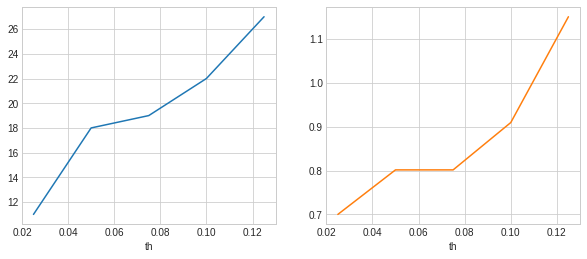

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10, 4)

metrics['max_size'].plot(ax=ax1)
metrics['max_diameter'].plot(ax=ax2, c='C1')

In [9]:
supernodes = build_supernodes(0.1)

supernodes.head(2)

,id,stops,diameter,types,lat,lon
0,0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


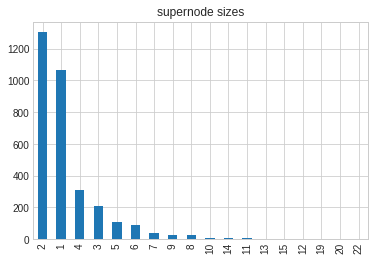

In [10]:
supernode_sizes = supernodes['stops'].apply(len).value_counts()

supernode_sizes.plot(kind='bar')
plt.title('supernode sizes');

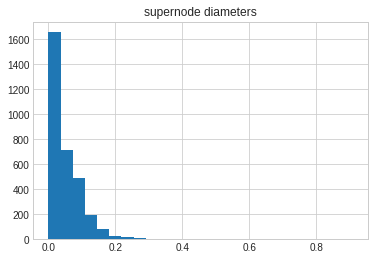

In [11]:
plt.hist(supernodes['diameter'], bins=25)
plt.title('supernode diameters');

In [12]:
supernodes_json = [row.to_dict() for _, row in supernodes.iterrows()]

supernodes_json[0]

{'id': 0,
 'stops': [29058,
  15366,
  1687,
  1688,
  15385,
  2080,
  2081,
  52,
  1337,
  24382,
  3268,
  2887,
  4046,
  29008,
  16603,
  31331,
  31332,
  31333,
  14692,
  16484,
  2549,
  25727],
 'diameter': 0.7329634436206482,
 'types': ['bus', 'trolley', 'tram', 'subway'],
 'lat': 59.85170995415688,
 'lon': 30.322415197727274}

In [13]:
save_json(supernodes_json, supernodes_fpath)

In [14]:
supernodes

,id,stops,diameter,types,lat,lon
0,0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.851710,30.322415
1,1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.950210,30.287937
2,2,"[16130, 23956, 22939, 25628, 16286, 30, 16289,...",0.469595,"[bus, tram, trolley, subway]",59.956716,30.354019
3,3,"[4609, 29290, 3082, 17005, 16142, 15984, 16466...",0.331043,"[bus, trolley, tram]",60.017943,30.367853
4,4,"[34, 16964, 4677, 19280, 2545, 26803, 16052, 1...",0.237753,"[bus, tram, trolley, subway]",59.990263,30.254647
...,...,...,...,...,...,...
3197,3197,[22320],0.000000,[bus],60.070908,30.394529
3198,3198,[0],0.000000,[subway],60.050325,30.442339
3199,3199,[5],0.000000,[subway],59.944505,30.359522
3200,3200,[58],0.000000,[subway],59.948532,30.234426


In [15]:
stop2supernode = {
    stop: supernode['id']
    for i, supernode in supernodes.iterrows()
    for stop in supernode['stops']
}

stops['supernode'] = stops['id'].map(stop2supernode)

stops.head(2)

,type,id,name,lat,lon,diameter,supernode
0,tram,16396,"Конечная станция ""Река Оккервиль""",59.908881,30.494671,0.0,620
1,tram,16367,Пр. Солидарности,59.911857,30.499882,0.0,827


In [16]:
stops_json = [row.to_dict() for _, row in stops.iterrows()]

save_json(stops_json, stops_fpath)

In [17]:
routes = pd.read_json(routes_fpath)

routes.head(2)

,name,type,direction,stops,id,distance,supernodes
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",11125,3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [18]:
def get_supernode_route(route: List[int]) -> List[int]:
    supernode_route = []
    
    for stop in route:
        supernode = stop2supernode[stop]
        
        if len(supernode_route) > 0 and supernode_route[-1] == supernode:
            continue
            
        supernode_route.append(supernode)
        
    return supernode_route


routes['supernodes'] = routes['stops'].apply(get_supernode_route)

routes.head(2)

,name,type,direction,stops,id,distance,supernodes
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",11125,3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [19]:
routes_json = [row.to_dict() for _, row in routes.iterrows()]

routes_json[0]

{'name': 'А',
 'type': 'tram',
 'direction': 1,
 'stops': [16396,
  16367,
  16371,
  16398,
  16400,
  16401,
  16405,
  16408,
  16410,
  16413,
  30720,
  27185,
  16415,
  33093],
 'id': 1125,
 'distance': 5.008429911444193,
 'supernodes': [620, 827, 828, 20, 309, 80, 310, 204, 5, 29, 118, 119, 30]}

In [20]:
save_json(routes_json, routes_fpath)